In [1]:
import pandas as pd

df = pd.read_csv('../data/eval/test.csv', encoding='utf-8')

In [2]:
df.head()

,User input,Retrieved Contexts,Response,Reference (Reference answer),Type,Source
0,Đối tượng được dự thi tiếng Anh nội bộ,NaN,NaN,Đối tượng được dự thi tiếng Anh nội bộ là toàn...,paragraph,Quy định tiếng Anh nội bộ
1,Hội đồng chấm thi tiếng Anh nội bộ gồm những ai,NaN,NaN,Hội đồng thi gồm:\n- Giám đốc ra quyết định th...,bullet,NaN
2,Các tiểu ban tổ chức thi tiếng Anh nội bộ,NaN,NaN,Chủ tịch HĐT ra quyết định thành lập các tiểu ...,paragraph,NaN
3,Nhiệm vụ của các tiểu ban trong tổ chức tiếng ...,NaN,NaN,- Tiểu ban Đề thi có nhiệm vụ tư vấn và tổ chứ...,NaN,NaN
4,Vai trò trong công tác tổ chức thi của các bên,NaN,NaN,a) Tiểu ban Coi thi – Tổ chức thi phối hợp với...,NaN,NaN


In [4]:
import weaviate
from sqlalchemy import (
    MetaData,
)
from flow.utils.utils import (
    get_llm,
    get_retriever,
    split_doc,
    get_embedding,
    get_vectorstore,
    get_retriever,
    get_websearch,
    get_table,
    get_sql_engine,
    get_database
)
from flow.model import Model

def build_comp():
    model = "llama3.1"
    text_dir = "/data/parse/text"

    # GET LLM
    llm = get_llm(model=model, format="",temperature=0)
    llm_json_mode = get_llm(model=model, format="json", temperature=0)

    # BUILD RETRIEVER
    # doc_list = split_doc(text_dir)
    embedding = get_embedding(model_name="BAAI/BGE-M3")

    client = weaviate.connect_to_local()
    vectorstore = get_vectorstore(client=client, embedding_model=embedding, index_name="Hust_doc_final")
    retriever = get_retriever(vectorstore=vectorstore, k=3)
    
    web_search_tool = get_websearch()

    # Build SQL Database
    metadata_obj = MetaData()
    table = get_table(table_name="teacher", metadata_obj=metadata_obj)
    engine = get_sql_engine()
    db = get_database(engine=engine, metadata_obj=metadata_obj)
    return llm, llm_json_mode, retriever, db, web_search_tool

llm, llm_json_mode, retriever, db, web_search_tool = build_comp()

In [5]:
pipeline = Model(llm, llm_json_mode, retriever, db, web_search_tool, verbose=True)

In [16]:
import json

file = {'question': [], 'answer': [], 'contexts': [], 'ground_truths': []}
for index, row in df.iterrows():
    question = row['User input']
    ground_truths = row['Reference (Reference answer)']
    
    response = pipeline.chat(query=question)
    
    answer = response['generation'].content
    ctx = [r.page_content for r in response['documents']]
    contexts = list(set(ctx))

    with open('ds.json', 'a'. enco) as f:
        file['question'].append(question)
        file['ground_truths'].append(ground_truths)
        file['answer'].append(answer)
        file['contexts'].append(contexts)    
        content = json.dumps(file)
        f.write(content)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


TypeError: dump() missing 1 required positional argument: 'fp'

In [6]:
res = pipeline.chat("Hội đồng chấm thi tiếng Anh nội bộ gồm những ai")

---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---DECISION: GENERATE---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


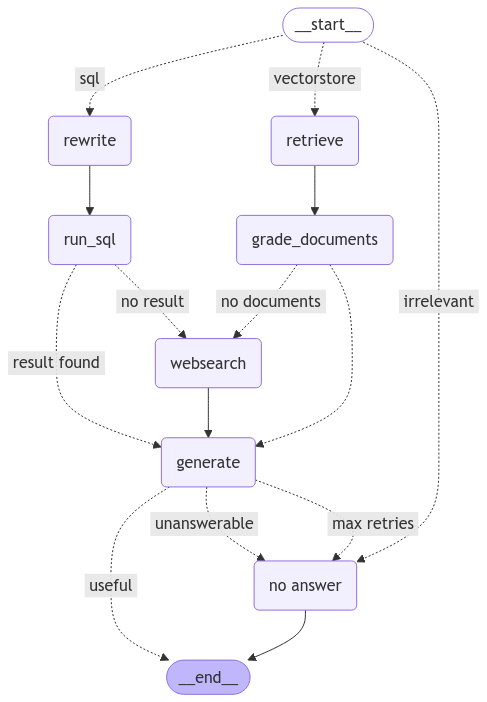

In [3]:
from IPython.display import Image, display

display(Image(pipeline.graph.get_graph().draw_mermaid_png()))

In [7]:
print(res['generation'].content)

Tôi xin lỗi, nhưng tôi không thể tìm thấy bất kỳ thông tin nào trong văn bản bạn cung cấp liên quan đến "Hội đồng chấm thi tiếng Anh nội bộ". Nếu bạn có thêm thông tin hoặc ngữ cảnh khác, vui lòng cho tôi biết để giúp bạn trả lời câu hỏi.


In [ ]:
def rag_eval(model, df, output_file="test.json"):
   
    file = {'question': [], 'answer': [], 'contexts': [], 'ground_truths': []}
    for _, row in tqdm(df.iterrows()):
        question = row['User input']
        ground_truths = row['Reference (Reference answer)']
        
        response = model.chat(query=question)
        
        answer = response['generation'].content
        ctx = [r.page_content for r in response['documents']]
        contexts = list(set(ctx))

        with open(output_file, 'a', encoding="utf-8") as f:
            file['question'].append(question)
            file['ground_truths'].append(ground_truths)
            file['answer'].append(answer)
            file['contexts'].append(contexts)    
            content = json.dumps(file, indent=2, ensure_ascii=False)
            f.write(content)
    return